## Прогнозирование стоимости автомобиля

In [1]:
import numpy as np 
import pandas as pd 
import sys
import time
import datetime
import requests as r
import json
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
#запишем функцию для вычисления итоговой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Парсинг

In [4]:
'''START_URL='https://auto.ru/moskva/cars/used/'

pages_url_list=[]'''

"START_URL='https://auto.ru/moskva/cars/used/'\n\npages_url_list=[]"

In [5]:
'''# ищем url'ы
while len(pages_url_list)<5000: 
    for i in range(1,99):   
        response = r.get( START_URL+'?page=%s'%i, headers={'User-Agent': 'Mozilla/5.0'})
        page = BeautifulSoup(response.text, 'html.parser')
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
            try:
                if link['href'] not in pages_url_list: 
                    pages_url_list.append(link['href'])
            except:
                pass
    print(len(pages_url_list))   
    time.sleep(10)'''

'# ищем url\'ы\nwhile len(pages_url_list)<5000: \n    for i in range(1,99):   \n        response = r.get( START_URL+\'?page=%s\'%i, headers={\'User-Agent\': \'Mozilla/5.0\'})\n        page = BeautifulSoup(response.text, \'html.parser\')\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n            try:\n                if link[\'href\'] not in pages_url_list: \n                    pages_url_list.append(link[\'href\'])\n            except:\n                pass\n    print(len(pages_url_list))   \n    time.sleep(10)'

In [6]:
'''# вытаскиваем данные из url'ов
cars_list = []
for item in pages_url_list:
    response = r.get(item)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
    if page.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        span_str = 'CardInfoRow__cell'
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find(
                'div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass
    time.sleep(0.1)'''

'# вытаскиваем данные из url\'ов\ncars_list = []\nfor item in pages_url_list:\n    response = r.get(item)\n    response.encoding = \'utf8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n    if page.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(\n                page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        span_str = \'CardInfoRow__cell\'\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n            \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n      

In [7]:
'''# переводим в DF
df = pd.DataFrame(cars_list)
# проверяем на дубликаты
df['sell_id'].duplicated().sum()
df.to_csv('cars.csv', index=False)'''

"# переводим в DF\ndf = pd.DataFrame(cars_list)\n# проверяем на дубликаты\ndf['sell_id'].duplicated().sum()\ndf.to_csv('cars.csv', index=False)"

# Setup

In [8]:
VERSION    = 16
DIR_TRAIN  = '../input/cars-df/'
DIR_TRAIN20 = '../input/all-auto-ru-09-09-2020/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [9]:
!ls '../input'

all-auto-ru-09-09-2020	cars-df  sf-dst-car-price-prediction


In [10]:
#разбиваем датасеты
train = pd.read_csv(DIR_TRAIN+'cars_df.csv')
train_2020 = pd.read_csv(DIR_TRAIN20+'all_auto_ru_09_09_2020.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [11]:
train.sample(5)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,equipmentGroups
9074,хэтчбек 3 дв.,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,синий,Спек:\n-D16y7 перебран на новых сальниках ремн...,1.4 LTR,75 N12,бензин,https://autoru.naydex.net/GvD9p2d78/563588CEak...,150 578 км,...,HATCHBACK_3_DOORS MECHANICAL 1.4,механическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,160 000 ₽,"[{'name': 'Комфорт', 'values': ['Регулировка р..."
2708,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/108...,белый,Авто в отличном состоянии. Своевременная замен...,1.2 LTR,105 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,75 000 км,...,LIFTBACK MECHANICAL 1.2,механическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,617 166 ₽,"[{'name': 'Безопасность', 'values': ['Креплени..."
29689,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/jett...,белый,авто в хорошем состоянии все разходники,1.4 LTR,122 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,245 000 км,...,SEDAN ROBOT 1.4,роботизированная,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,530 000 ₽,"[{'name': 'Безопасность', 'values': ['Антиблок..."
29224,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,синий,Приветствую всех кто смотрит данное сообщение....,1.6 LTR,105 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,46 181 км,...,SEDAN AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,730 000 ₽,"[{'name': 'Безопасность', 'values': ['Подушка ..."
33344,внедорожник 5 дв.,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/mont...,чёрный,Двигатель сделан.коробка контрактная поменяна ...,3.5 LTR,200 N12,бензин,https://autoru.naydex.net/niW1n0020/9d30ffRJ/d...,300 000 км,...,ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,490 000 ₽,"[{'name': 'Безопасность', 'values': ['Антиблок..."


In [12]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34240 entries, 0 to 34239
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34240 non-null  object
 1   brand                 34240 non-null  object
 2   car_url               34240 non-null  object
 3   color                 34240 non-null  object
 4   description           34240 non-null  object
 5   engineDisplacement    34240 non-null  object
 6   enginePower           34240 non-null  object
 7   fuelType              34240 non-null  object
 8   image                 34240 non-null  object
 9   mileage               34240 non-null  object
 10  modelDate             34240 non-null  int64 
 11  model_name            34240 non-null  object
 12  name                  34240 non-null  object
 13  numberOfDoors         34240 non-null  int64 
 14  parsing_unixtime      34240 non-null  int64 
 15  priceCurrency         34240 non-null

bodyType                   0
brand                      0
car_url                    0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
image                      0
mileage                    0
modelDate                  0
model_name                 0
name                       0
numberOfDoors              0
parsing_unixtime           0
priceCurrency              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
ПТС                        0
Привод                     0
Руль                       0
Состояние                  0
Таможня                    0
price                      0
equipmentGroups         8032
dtype: int64

In [13]:
test.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
21746,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/mark_ii/...,чёрный,NaN,"Турер s с завода,рестайлинговая оптика с желтк...",2.5 LTR,200 N12,NaN,бензин,...,SEDAN AUTOMATIC 2.5,автоматическая,JAPANESE,3 или более,NaN,Дубликат,задний,Правый,Не требует ремонта,Растаможен
29449,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/11013330...,чёрный,NaN,Единственный в своём роде\n 7 местный Х5 F15 с...,3.0 LTR,249 N12,"{""wheel-heat"":true,""decorative-interior-lighti...",дизель,...,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,2 владельца,4 года и 8 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
2554,седан,AUDI,https://auto.ru/cars/used/sale/audi/a8/1101276...,чёрный,NaN,- Комфортные передние сиденья\n- Доводчики две...,3.0 LTR,310 N12,"{""cruise-control"":true,""airbag-driver"":true,""e...",бензин,...,SEDAN AUTOMATIC 3.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
13242,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/almera/1...,белый,NaN,машина очень хорошем состоянии не был ДТП,1.6 LTR,102 N12,NaN,бензин,...,SEDAN AUTOMATIC 1.6,автоматическая,JAPANESE,3 или более,9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
11491,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/qashqai/...,серебристый,"{""id"":""6129710"",""name"":""SE+"",""available_option...",АRMAND - официальный Дилер KIA\n\n\n\nАвтомоби...,2.0 LTR,141 N12,"{""cruise-control"":true,""esp"":true,""airbag-driv...",бензин,...,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,JAPANESE,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
test.info()
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [15]:
pd.set_option('display.max_columns', None)
print('train data: ', train.shape)
display(train.head(5))
print('test data: ', test.shape)
display(test.head(5))

train data:  (34240, 28)


,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,equipmentGroups
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,Машине нужны любящие руки понимающего человека...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,205 500 км,2008,Skoda Octavia II (A5) Рестайлинг,1.8 MT,5,1628872293,RUB,2012,№ 1104849127,LIFTBACK MECHANICAL 1.8,механическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,620 999 ₽,"[{'name': 'Безопасность', 'values': ['Антиблок..."
1,компактвэн,SKODA,https://auto.ru/cars/used/sale/skoda/roomster/...,серый,🔆Добрый день! Просьба приезжать в маске! \n👁Ос...,1.4 LTR,86 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,86 602 км,2010,Skoda Roomster I Рестайлинг,1.4 MT,5,1628872296,RUB,2012,№ 1104891539,COMPACTVAN MECHANICAL 1.4,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,699 000 ₽,"[{'name': 'Безопасность', 'values': ['Подушка ..."
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,бежевый,Отличное состояние.\nБез дтп.\nЯ второй владел...,1.4 LTR,80 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,275 000 км,2004,Skoda Octavia II (A5),1.4 MT,5,1628872299,RUB,2008,№ 1103946594,LIFTBACK MECHANICAL 1.4,механическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,349 000 ₽,"[{'name': 'Комфорт', 'values': ['Кондиционер',..."
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,Ваш выбор и Ваше время — наши главные приорите...,1.4 LTR,150 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,3 956 км,2019,Skoda Octavia IV (A8),1.4 AT,5,1628872303,RUB,2021,№ 1104908952,LIFTBACK AUTOMATIC 1.4,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2 129 000 ₽,"[{'name': 'Безопасность', 'values': ['Подушка ..."
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,чёрный,Ваш выбор и Ваше время — наши главные приорите...,1.6 LTR,110 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,4 415 км,2020,Skoda Rapid II,1.6 AT,5,1628872305,RUB,2021,№ 1104908932,LIFTBACK AUTOMATIC 1.6,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1 328 000 ₽,"[{'name': 'Безопасность', 'values': ['Подушка ..."


test data:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


## Инфляция

In [16]:
# удаляем знак валюты и пробелы в цене
train['price'] =train['price'].astype(str)
train['price'] = train['price'].apply(lambda x: x if len(x) ==1 else ''.join(x.split()[0:-1])).astype(int)

In [17]:
# смотрим инфляцию по брендам
brands = test.brand.unique()
infos = []
for brand in brands:
    mean20 = train_2020[train_2020["brand"]==brand].price.mean()
    mean21 = train[train["brand"]==brand].price.mean()
    inf = (mean21-mean20)/mean20
    infos.append(inf)
    print(f'{brand} 2020: {mean20}')
    print(f'{brand} 2021: {mean21}')
    print(f'Инфляция: {round(inf * 100,2)}%')
    print()

SKODA 2020: 657326.633273703
SKODA 2021: 910444.3177229388
Инфляция: 38.51%

AUDI 2020: 1502616.5201474202
AUDI 2021: 1677113.6928999145
Инфляция: 11.61%

HONDA 2020: 595388.4040920716
HONDA 2021: 699112.622754491
Инфляция: 17.42%

VOLVO 2020: 1776484.3166828323
VOLVO 2021: 1233911.1361125063
Инфляция: -30.54%

BMW 2020: 2387441.4331296673
BMW 2021: 2466772.130835735
Инфляция: 3.32%

NISSAN 2020: 891387.644173913
NISSAN 2021: 931886.534647724
Инфляция: 4.54%

INFINITI 2020: 1564960.196911197
INFINITI 2021: 1602153.632780083
Инфляция: 2.38%

MERCEDES 2020: 3526259.7003383883
MERCEDES 2021: 3435923.9598136283
Инфляция: -2.56%

TOYOTA 2020: 1348232.2266944733
TOYOTA 2021: 1764081.6214222484
Инфляция: 30.84%

LEXUS 2020: 2025737.124282983
LEXUS 2021: 2708173.126965638
Инфляция: 33.69%

VOLKSWAGEN 2020: 999332.647869498
VOLKSWAGEN 2021: 1113360.6555655566
Инфляция: 11.41%

MITSUBISHI 2020: 994034.449859658
MITSUBISHI 2021: 874427.4276932084
Инфляция: -12.03%



In [18]:
# учитываем инфляцию и меняем цены
brands = test.brand.unique()
temp_data = train.copy()
display(temp_data.head(2))
for brand in brands:
    mean20 = train_2020[train_2020["brand"]==brand].price.mean()
    mean21 = train[train["brand"]==brand].price.mean()
    inf = (mean21-mean20)/mean20
    if inf>0:
        temp_data.loc[temp_data["brand"]==brand, ['price']] = temp_data.loc[temp_data["brand"]==brand, ['price']].apply(lambda x: round(x/(1+inf),0))
display(temp_data.head(2))

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,equipmentGroups
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,Машине нужны любящие руки понимающего человека...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,205 500 км,2008,Skoda Octavia II (A5) Рестайлинг,1.8 MT,5,1628872293,RUB,2012,№ 1104849127,LIFTBACK MECHANICAL 1.8,механическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,620999,"[{'name': 'Безопасность', 'values': ['Антиблок..."
1,компактвэн,SKODA,https://auto.ru/cars/used/sale/skoda/roomster/...,серый,🔆Добрый день! Просьба приезжать в маске! \n👁Ос...,1.4 LTR,86 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,86 602 км,2010,Skoda Roomster I Рестайлинг,1.4 MT,5,1628872296,RUB,2012,№ 1104891539,COMPACTVAN MECHANICAL 1.4,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,699000,"[{'name': 'Безопасность', 'values': ['Подушка ..."


,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,equipmentGroups
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,Машине нужны любящие руки понимающего человека...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,205 500 км,2008,Skoda Octavia II (A5) Рестайлинг,1.8 MT,5,1628872293,RUB,2012,№ 1104849127,LIFTBACK MECHANICAL 1.8,механическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,448352.0,"[{'name': 'Безопасность', 'values': ['Антиблок..."
1,компактвэн,SKODA,https://auto.ru/cars/used/sale/skoda/roomster/...,серый,🔆Добрый день! Просьба приезжать в маске! \n👁Ос...,1.4 LTR,86 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,86 602 км,2010,Skoda Roomster I Рестайлинг,1.4 MT,5,1628872296,RUB,2012,№ 1104891539,COMPACTVAN MECHANICAL 1.4,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,504667.0,"[{'name': 'Безопасность', 'values': ['Подушка ..."


In [19]:
train = temp_data

In [20]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34240 entries, 0 to 34239
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34240 non-null  object 
 1   brand                 34240 non-null  object 
 2   car_url               34240 non-null  object 
 3   color                 34240 non-null  object 
 4   description           34240 non-null  object 
 5   engineDisplacement    34240 non-null  object 
 6   enginePower           34240 non-null  object 
 7   fuelType              34240 non-null  object 
 8   image                 34240 non-null  object 
 9   mileage               34240 non-null  object 
 10  modelDate             34240 non-null  int64  
 11  model_name            34240 non-null  object 
 12  name                  34240 non-null  object 
 13  numberOfDoors         34240 non-null  int64  
 14  parsing_unixtime      34240 non-null  int64  
 15  priceCurrency      

bodyType                   0
brand                      0
car_url                    0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
image                      0
mileage                    0
modelDate                  0
model_name                 0
name                       0
numberOfDoors              0
parsing_unixtime           0
priceCurrency              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
ПТС                        0
Привод                     0
Руль                       0
Состояние                  0
Таможня                    0
price                      0
equipmentGroups         8032
dtype: int64

## Data Preprocessing

In [21]:
print(train.columns)
print(train_2020.columns)
print(test.columns)

Index(['bodyType', 'brand', 'car_url', 'color', 'description',
       'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime',
       'priceCurrency', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'price', 'equipmentGroups'],
      dtype='object')
Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')
Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
   

In [22]:
# Создадим список общих переменных для теста и трейна:
s2020 = list(train_2020.columns)
s2021 = list(train.columns)
s = set(list(test.columns))
no2020 = [x for x in s if not x in s2020] #найдем стобцы, которых нет в трейне
print('Столбцы, которые есть в тесте, но их нет в трейне 2020:', no2020)
no2021 = [x for x in s if not x in s2021] #найдем стобцы, которых нет в трейне
print('Столбцы, которые есть в тесте, но их нет в трейне 2021:', no2021)

Столбцы, которые есть в тесте, но их нет в трейне 2020: ['model_name', 'model_info', 'super_gen', 'equipment_dict', 'vendor', 'image', 'car_url', 'complectation_dict', 'parsing_unixtime', 'sell_id', 'priceCurrency']
Столбцы, которые есть в тесте, но их нет в трейне 2021: ['model_info', 'super_gen', 'equipment_dict', 'vendor', 'Владение', 'complectation_dict']


In [23]:
train['equipment_dict'] = train['equipmentGroups']
train = train.drop(['equipmentGroups'], axis=1)

train.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'description',
       'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime',
       'priceCurrency', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'price', 'equipment_dict'],
      dtype='object')

In [24]:
train_2020['sell_id'] = 0
train['sell_id'] = 0
train_2020['car_url'] = train_2020['model']

In [25]:
# список общих переменных
columns2021 = [x for x in s2021 if not x in no2021]
print('Общие для 2021')
print('Общее количество', len(columns2021))
print(columns2021)

columns2020 = [x for x in s2020 if not x in no2020]
print('Общие для 2020')
print('Общее количество', len(columns2020))
print(columns2020)

Общие для 2021
Общее количество 28
['bodyType', 'brand', 'car_url', 'color', 'description', 'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'price', 'equipmentGroups']
Общие для 2020
Общее количество 26
['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower', 'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date', 'hidden', 'model']


In [26]:
to_del = ['image','parsing_unixtime','priceCurrency','description','model_name', 'Состояние','equipmentGroups']

In [27]:
columns = [x for x in columns2021 if not x in to_del] 
columns = ([x for x in columns if x in columns2020+['car_url', 'sell_id']] )

In [28]:
test['price']=0

df_train_2020 = train_2020[columns]
df_train = train[columns]
df_test = test[columns]

In [29]:
df_train_2020['sample'] = 1 # помечаем где у нас трейн
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).append(df_train_2020, sort=False).reset_index(drop=True) # объединяем
data[data['sample']==0].shape

(34686, 22)

In [30]:
data.sample(5)

,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Таможня,price,sample
55559,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/gls_kl...,белый,3.0 LTR,249 N12,дизель,52 560 км,2015.0,3.0 AT,5.0,2018,0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,Оригинал,полный,Левый,Растаможен,5199000.0,1
137858,Внедорожник 5 дв.,TOYOTA,RAV_4,200204,2.0,149.0,бензин,0,2018.0,2.0 CVT (149 л.с.) 4WD,5.0,2020,0,ALLROAD_5_DOORS VARIATOR 2.0,VARIATOR,NaN,ORIGINAL,полный,LEFT,True,2405000.0,1
129850,Лифтбек,SKODA,OCTAVIA,FAFBFB,1.6,110.0,бензин,0,2017.0,1.6 AT (110 л.с.),5.0,2020,0,LIFTBACK AUTOMATIC 1.6,AUTOMATIC,NaN,ORIGINAL,передний,LEFT,True,1338900.0,1
109694,Седан,MAZDA,626,FAFBFB,2.0,120.0,бензин,350000,1982.0,2.0 AT (120 л.с.),4.0,1986,0,SEDAN AUTOMATIC 2.0,AUTOMATIC,3.0,ORIGINAL,передний,LEFT,True,43000.0,1
144214,Внедорожник 5 дв.,VOLKSWAGEN,TIGUAN,CACECB,2.0,170.0,бензин,146700,2007.0,2.0 AT (170 л.с.) 4WD,5.0,2011,0,ALLROAD_5_DOORS AUTOMATIC 2.0,AUTOMATIC,3.0,ORIGINAL,полный,LEFT,True,600000.0,1


In [31]:
#перепроверяем на дубликаты
data['car_url'].value_counts()
data = data.drop_duplicates(subset=['car_url'])

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69229 entries, 0 to 158301
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              69229 non-null  object 
 1   brand                 69229 non-null  object 
 2   car_url               69229 non-null  object 
 3   color                 69229 non-null  object 
 4   engineDisplacement    69229 non-null  object 
 5   enginePower           69229 non-null  object 
 6   fuelType              69229 non-null  object 
 7   mileage               69229 non-null  object 
 8   modelDate             69229 non-null  float64
 9   name                  69229 non-null  object 
 10  numberOfDoors         69229 non-null  float64
 11  productionDate        69229 non-null  int64  
 12  sell_id               69229 non-null  int64  
 13  vehicleConfiguration  69229 non-null  object 
 14  vehicleTransmission   69229 non-null  object 
 15  Владельцы         

In [33]:
data.isna().sum()

bodyType                 0
brand                    0
car_url                  0
color                    0
engineDisplacement       0
enginePower              0
fuelType                 0
mileage                  0
modelDate                0
name                     0
numberOfDoors            0
productionDate           0
sell_id                  0
vehicleConfiguration     0
vehicleTransmission      0
Владельцы               54
ПТС                      5
Привод                   0
Руль                     0
Таможня                  0
price                    0
sample                   0
dtype: int64

# Features 

In [34]:
#числовые:
num_cols = []

# бинарные
bin_cols = []

# категориальные
cat_cols = []

**bodyType**

In [35]:
data.bodyType.value_counts()

внедорожник 5 дв.                26269
седан                            23656
лифтбек                           5096
хэтчбек 5 дв.                     3945
универсал 5 дв.                   2485
                                 ...  
Пикап Двойная кабина Crew Cab        1
Компактвэн Gran Tourer               1
фастбек                              1
универсал 3 дв.                      1
Минивэн L2                           1
Name: bodyType, Length: 79, dtype: int64

In [36]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [37]:
data.bodyType.value_counts()

внедорожник      26736
седан            23942
лифтбек           5109
хэтчбек           4960
универсал         2539
минивэн           1768
купе              1724
компактвэн         933
пикап              583
купе-хардтоп       286
родстер            195
кабриолет          192
фургон             189
микровэн            37
седан-хардтоп       22
лимузин              7
тарга                4
фастбек              3
Name: bodyType, dtype: int64

<AxesSubplot:>

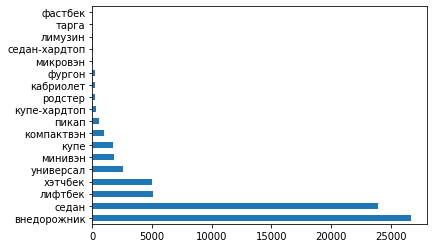

In [38]:
#распределение
data.bodyType.value_counts().plot.barh() 

In [39]:
cat_cols.append('bodyType')

**brand**

In [40]:
data.brand.value_counts()

BMW           7854
NISSAN        7846
VOLKSWAGEN    7713
MERCEDES      7557
TOYOTA        7347
AUDI          6905
SKODA         6265
MITSUBISHI    6249
VOLVO         3423
HONDA         3172
LEXUS         2535
INFINITI      1828
FORD            53
CHEVROLET       46
MAZDA           40
HYUNDAI         38
KIA             34
OPEL            33
CITROEN         28
PEUGEOT         27
RENAULT         27
SUZUKI          25
SUBARU          20
CHERY           19
CHRYSLER        18
GREAT_WALL      15
CADILLAC        15
PORSCHE         15
DODGE           14
JAGUAR          14
DAEWOO          12
GEELY           10
SSANG_YONG      10
LAND_ROVER       9
JEEP             8
MINI             5
Name: brand, dtype: int64

In [41]:
cat_cols.append('brand')

**color**

In [42]:
data.color.value_counts()

чёрный         21147
белый          13219
серый           8202
серебристый     7404
синий           6332
коричневый      3078
красный         3060
зелёный         1678
бежевый         1185
голубой          813
золотистый       490
пурпурный        446
фиолетовый       404
жёлтый           402
оранжевый        263
040001           243
FAFBFB           200
0000CC           130
97948F           130
CACECB           117
EE1D19            80
007F00            53
200204            37
розовый           20
22A0F8            17
C49648            17
660099            17
4A2197            14
FFD600            14
DEA522             8
FF8649             8
FFC0CB             1
Name: color, dtype: int64

<AxesSubplot:>

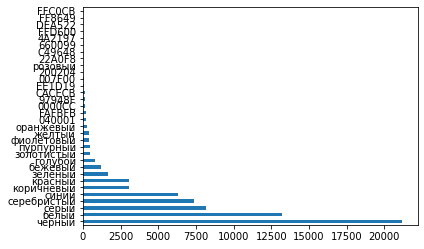

In [43]:
data.color.value_counts().plot.barh() 

In [44]:
cat_cols.append('color')

**fuelType**

In [45]:
data.fuelType.value_counts()

бензин     56416
дизель     12103
гибрид       555
электро      143
газ           12
Name: fuelType, dtype: int64

<AxesSubplot:xlabel='fuelType', ylabel='count'>

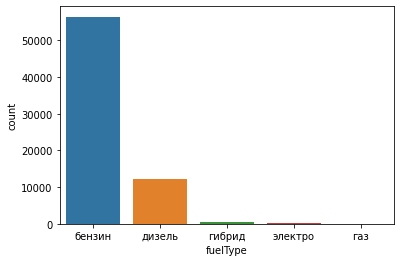

In [46]:
sns.countplot(x = 'fuelType', data = data)

In [47]:
cat_cols.append('fuelType')

**engineDisplacement**

In [48]:
data.engineDisplacement.value_counts()

2.0 LTR    15558
1.6 LTR     9811
3.0 LTR     7636
1.8 LTR     5870
2.5 LTR     4769
           ...  
2.6            1
V10            1
ST220          1
Raptor         1
2.9d           1
Name: engineDisplacement, Length: 220, dtype: int64

In [49]:
data['engineDisplacement'] = data['engineDisplacement'].astype(str)

In [50]:
data['engineDisplacement'] = data['engineDisplacement'].str.extract('(\d.\d)',expand=False).str.strip()

In [51]:
data['engineDisplacement']=data['engineDisplacement'].astype(float)

In [52]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: round(x/100,1) if (x>10) else round(x,1))

In [53]:
mean = round(data['engineDisplacement'].mean(),1)
mean

2.4

In [54]:
data[data['sample']==0]['engineDisplacement'].isnull().sum()

55

In [55]:
data['engineDisplacement'].fillna(mean, inplace=True)

<AxesSubplot:>

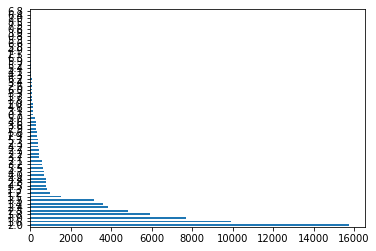

In [56]:
data['engineDisplacement'].value_counts().plot.barh()

In [57]:
num_cols.append('engineDisplacement')

**enginePower**

In [58]:
data.enginePower.value_counts()

150 N12    3984
249 N12    3915
110 N12    2437
140 N12    1871
170 N12    1807
           ... 
330.0         1
228.0         1
350.0         1
20.0          1
258.0         1
Name: enginePower, Length: 601, dtype: int64

In [59]:
data['enginePower'] = data['enginePower'].astype(str).apply(lambda x: x.split()[0])
data['enginePower'] = data['enginePower'].astype(float)

In [60]:
data['enginePower'].value_counts()

150.0    4032
249.0    3932
110.0    2454
140.0    1908
170.0    1825
         ... 
338.0       1
164.0       1
564.0       1
345.0       1
63.0        1
Name: enginePower, Length: 364, dtype: int64

In [61]:
data['enginePower'].value_counts().sort_index()

17.0     1
19.0     1
20.0     1
30.0     2
32.0     2
        ..
630.0    1
635.0    1
639.0    7
646.0    1
761.0    1
Name: enginePower, Length: 364, dtype: int64

In [62]:
# Разобьём признак на категории
def enginePower(x):
    if x < 100: x = 1
    elif 99 < x < 150: x = 2
    elif 149 < x < 200: x = 3
    elif 199 < x < 250: x = 4
    elif 249 < x < 300: x = 5
    elif 299 < x < 350: x = 6
    elif 349 < x < 400: x = 7
    elif 399 < x < 450: x = 8
    elif 449 < x < 500: x = 9
    elif 499 < x < 550: x = 10
    elif 549 < x < 600: x = 11
    else: x = 12
    return x  

In [63]:
data['enginePower'] = data['enginePower'].map(enginePower)

Text(0.5, 1.0, 'Мощность двигателя в л.с.')

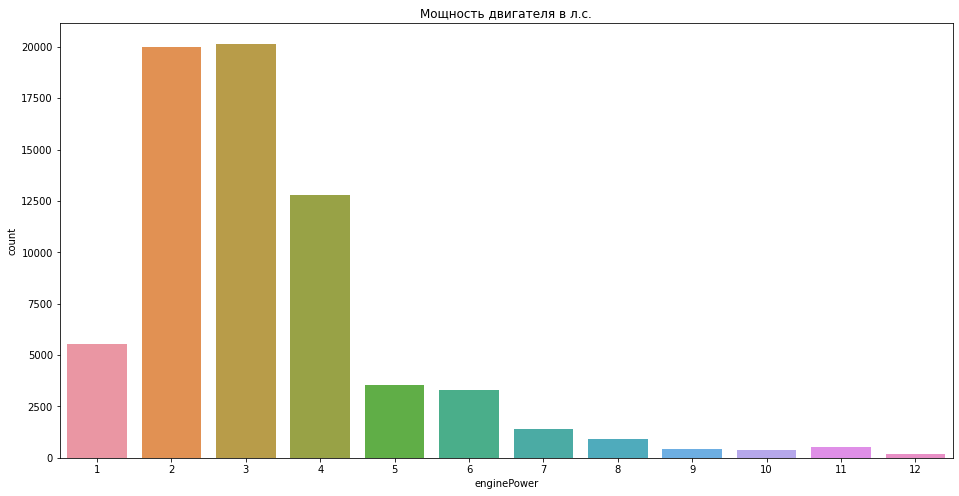

In [64]:
plt.figure(figsize=(16,8))
sns.countplot(x = data['enginePower'], data = data) 
plt.title('Мощность двигателя в л.с.')

In [65]:
num_cols.append('enginePower')

**mileage**

In [66]:
data['mileage'].value_counts()

200000    455
300000    392
150000    391
160000    362
180000    356
         ... 
263507      1
205837      1
43244       1
70700       1
106124      1
Name: mileage, Length: 24978, dtype: int64

In [67]:
#очищаем данные
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [68]:
data['mileage'] = data.mileage.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

count      69229.000000
mean      155406.667582
std        99525.381978
min            0.000000
25%        83700.000000
50%       142416.000000
75%       208313.000000
max      1000000.000000
Name: mileage, dtype: float64

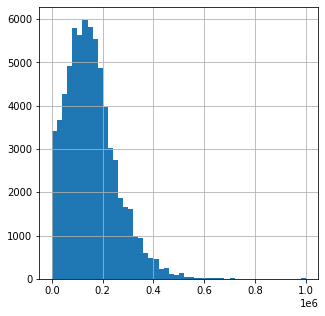

In [69]:
data['mileage'].hist(figsize=(5,5), bins=50)
data.mileage.describe()

In [70]:
#создадим признак 'mileage_cat'  
data["mileage_cat"] = data["mileage"].apply(lambda x: 4 if x>=40000 else(3 if x>=30000 else(2 if x>=20000 else (1 if x>=10000 else 0))))

In [71]:
data.mileage_cat.value_counts()

4    62164
3     1940
0     1771
2     1717
1     1637
Name: mileage_cat, dtype: int64

In [72]:
num_cols.append('mileage')
cat_cols.append('mileage_cat')

**productionDate и modelDate**

In [73]:
data.productionDate.value_counts()

2012    5347
2013    4867
2011    4656
2008    4558
2014    4553
        ... 
1946       1
1955       1
1931       1
1923       1
1949       1
Name: productionDate, Length: 76, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


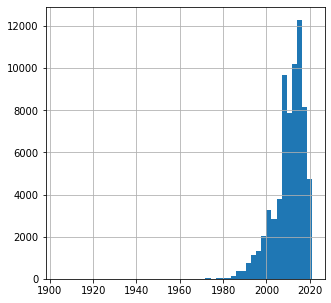

In [74]:
print(data['productionDate'].hist(figsize=(5,5), bins=50))

In [75]:
data.modelDate.value_counts()

2013.0    5156
2010.0    4654
2014.0    4457
2012.0    4357
2015.0    4251
          ... 
1908.0       1
1935.0       1
1948.0       1
1950.0       1
1953.0       1
Name: modelDate, Length: 79, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


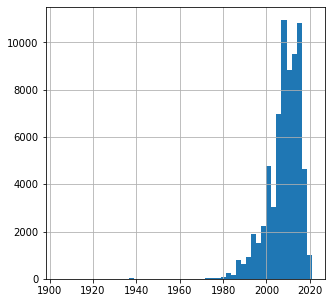

In [76]:
print(data['modelDate'].hist(figsize=(5,5), bins=50))

In [77]:
#создадим новые признаки на основе существующих: количество лет производства и возраст модели
data['prod_age'] = 2021 - data.productionDate
data['model_age'] = 2021 - data.modelDate

In [78]:
#определим эти признаки в числовые данные
num_cols.append('productionDate')
num_cols.append('modelDate')
num_cols.append('prod_age')
num_cols.append('model_age')

**numberOfDoors**

In [79]:
data.numberOfDoors.value_counts() 

5.0    39878
4.0    25677
2.0     2465
3.0     1207
0.0        2
Name: numberOfDoors, dtype: int64

<AxesSubplot:xlabel='numberOfDoors', ylabel='count'>

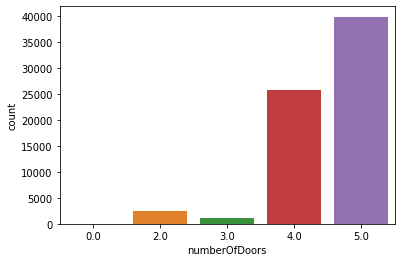

In [80]:
sns.countplot(x = 'numberOfDoors', data = data)

In [81]:
cat_cols.append('numberOfDoors')

**sell_id**

In [82]:
test.sell_id.isna().sum()

0

**vehicleTransmission**

In [83]:
data.vehicleTransmission.value_counts()

автоматическая      38039
механическая        13655
роботизированная     8226
вариатор             8223
AUTOMATIC             586
MECHANICAL            328
ROBOT                  89
VARIATOR               83
Name: vehicleTransmission, dtype: int64

<AxesSubplot:xlabel='vehicleTransmission', ylabel='count'>

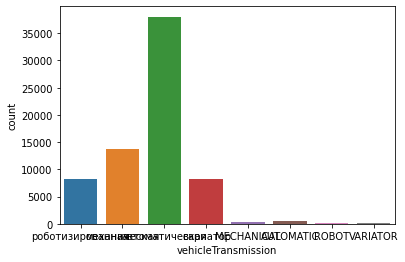

In [84]:
sns.countplot(x = 'vehicleTransmission', data = data)

In [85]:
#определяем в категориальный признак
cat_cols.append('vehicleTransmission')

**Владельцы**

In [86]:
data['Владельцы'].value_counts(dropna=False)

3 или более    29874
1 владелец     20352
2 владельца    17917
3.0              491
1.0              307
2.0              234
NaN               54
Name: Владельцы, dtype: int64

In [87]:
data['Владельцы'] = data['Владельцы'].astype(
                str).apply(lambda x: x if len(x) == 1 else x.split())
data['Владельцы']

0         [3, или, более]
1           [1, владелец]
2           [1, владелец]
3           [1, владелец]
4           [1, владелец]
               ...       
157904              [1.0]
158170              [3.0]
158179              [2.0]
158296              [1.0]
158301              [1.0]
Name: Владельцы, Length: 69229, dtype: object

In [88]:
data['Владельцы']= data['Владельцы'].apply(
    lambda x: x[0].lower() if len(x) == 1 else x[0].lower())

In [89]:
data['Владельцы']=data['Владельцы'].astype(float)
mode = round(data['Владельцы'].mode(),0)
mode

0    3.0
dtype: float64

In [90]:
data['Владельцы'].fillna(3, inplace=True)

In [91]:
cat_cols.append('Владельцы')

**ПТС**

In [92]:
data.ПТС.value_counts()

Оригинал     58962
Дубликат      9180
ORIGINAL       942
DUPLICATE      140
Name: ПТС, dtype: int64

In [93]:
data.ПТС.isna().sum()

5

In [94]:
# заполняем пропуск наиболее частым значением
data.ПТС = data.ПТС.fillna('Оригинал')

In [95]:
# Преобразуем значения в колонке ПТС
data['ПТС'] = data['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

<AxesSubplot:xlabel='ПТС', ylabel='count'>

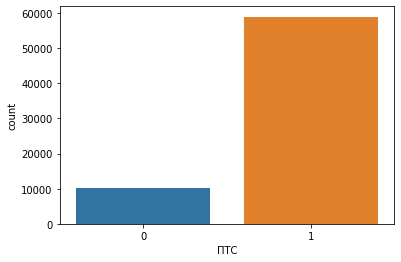

In [96]:
sns.countplot(x = 'ПТС', data = data)

In [97]:
#определяем в бинарные признаки
bin_cols.append('ПТС')

**Привод**

In [98]:
data.Привод.value_counts()

полный      31561
передний    30705
задний       6963
Name: Привод, dtype: int64

<AxesSubplot:xlabel='Привод', ylabel='count'>

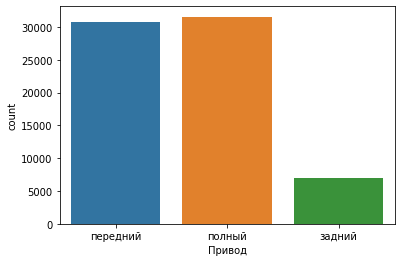

In [99]:
#смотрим на распределение
sns.countplot(x = 'Привод', data = data)

In [100]:
cat_cols.append('Привод')

**Руль**

In [101]:
data.Руль.value_counts()

Левый     65526
Правый     2617
LEFT        876
RIGHT       210
Name: Руль, dtype: int64

In [102]:
# преобразуем значения в колонке Руль
data['Руль'] = data['Руль'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

<AxesSubplot:xlabel='Руль', ylabel='count'>

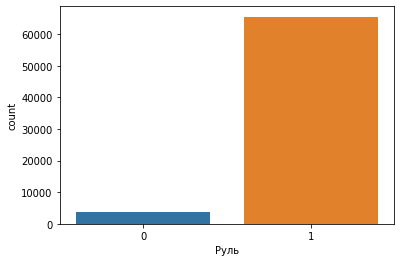

In [103]:
sns.countplot(x = 'Руль', data = data)

In [104]:
bin_cols.append('Руль')

**Посмотрим на распределение целевой переменной:**

In [105]:
# приведем целевую переменную к числовому типу
data['price'] = data['price'].apply(lambda x: str(x))

In [106]:
data.price = data.price.apply(
    lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

<AxesSubplot:title={'center':'Распределение price'}, xlabel='price'>

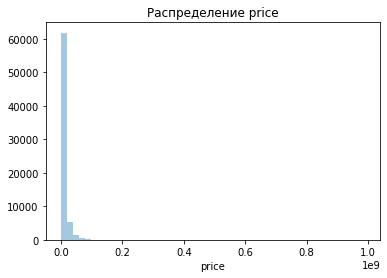

In [107]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(data.price, kde=False)

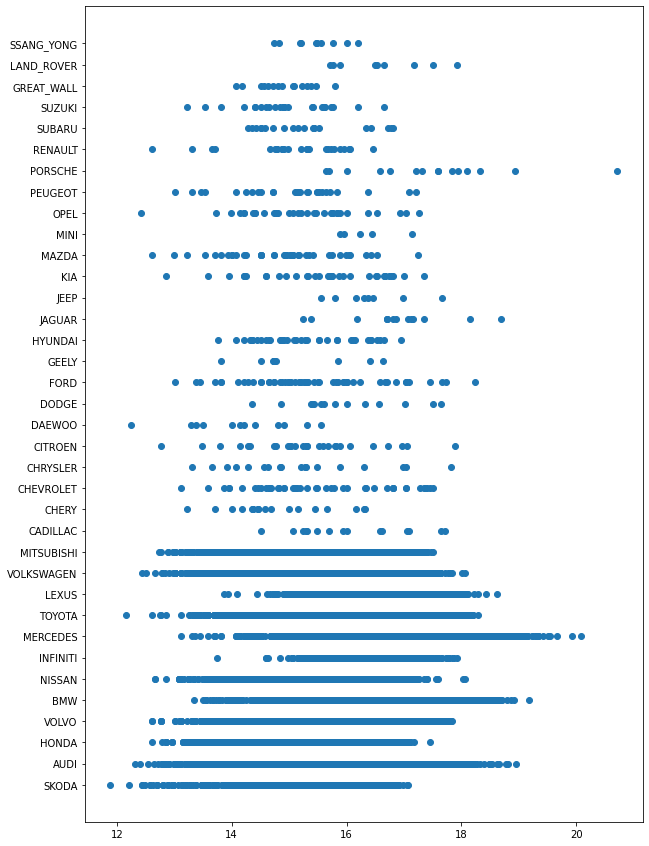

In [108]:
#смотрим на распределение зависимости цены от марки авто:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.brand)

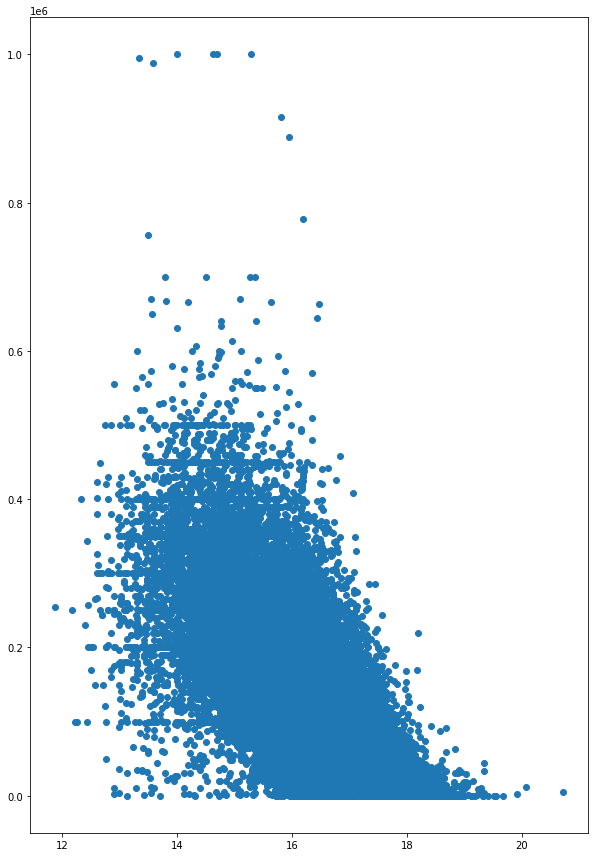

In [109]:
#смотрим на распределение зависимости цены от километража
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.mileage)

In [110]:
#удалим признаки, которые не несут никакой информативности:
data = data.drop(columns = ['car_url','name','sell_id','vehicleConfiguration','Таможня'], axis=1)

In [111]:
data.head(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,price,sample,mileage_cat,prod_age,model_age
0,лифтбек,SKODA,синий,1.2,2,бензин,74000,2013.0,5.0,2014,роботизированная,3.0,1,передний,1,0,0,4,7,8.0
1,лифтбек,SKODA,чёрный,1.6,2,бензин,60563,2017.0,5.0,2017,механическая,1.0,1,передний,1,0,0,4,4,4.0
2,лифтбек,SKODA,серый,1.8,3,бензин,88000,2013.0,5.0,2014,роботизированная,1.0,1,передний,1,0,0,4,7,8.0
3,лифтбек,SKODA,коричневый,1.6,2,бензин,95000,2013.0,5.0,2014,автоматическая,1.0,1,передний,1,0,0,4,7,8.0
4,лифтбек,SKODA,белый,1.8,3,бензин,58536,2008.0,5.0,2012,автоматическая,1.0,1,передний,1,0,0,4,9,13.0


## Label Encoding

In [112]:
for colum in ['bodyType','color','brand','fuelType', 'vehicleTransmission','Привод']:
    data[colum] = data[colum].astype('category').cat.codes

In [113]:
data.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,price,sample,mileage_cat,prod_age,model_age
30865,16,34,17,1.9,1,3,431246,1990.0,3.0,2000,6,3.0,1,1,1,0,0,4,21,31.0
51547,0,24,27,2.0,2,0,213686,2007.0,5.0,2007,5,3.0,1,2,1,5729680,1,4,14,14.0
51732,0,24,31,1.6,2,0,118960,2010.0,5.0,2013,5,2.0,1,1,1,7164490,1,4,8,11.0
32618,11,24,28,1.8,2,0,133740,2002.0,4.0,2005,4,2.0,1,1,1,0,0,4,16,19.0
63461,8,34,31,2.0,3,3,368000,2009.0,4.0,2011,7,2.0,1,1,1,13445780,1,4,10,12.0


In [114]:
print('Категориальныe: {} \nБинарные: {}\nЧисловые: {}'.format(cat_cols, bin_cols,num_cols))

Категориальныe: ['bodyType', 'brand', 'color', 'fuelType', 'mileage_cat', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
Бинарные: ['ПТС', 'Руль']
Числовые: ['engineDisplacement', 'enginePower', 'mileage', 'productionDate', 'modelDate', 'prod_age', 'model_age']


# Bin

In [115]:
for i in bin_cols:
    display(data[i].value_counts())

1    58967
0    10262
Name: ПТС, dtype: int64

1    65526
0     3703
Name: Руль, dtype: int64

<AxesSubplot:>

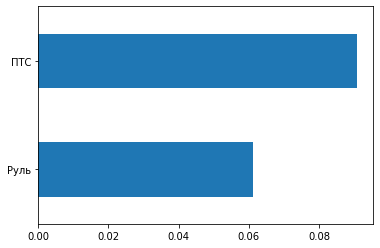

In [116]:
#проверяем значимость бинарных переменных:
df = data[data['sample'] == 0]
imp_cat = Series(mutual_info_classif(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

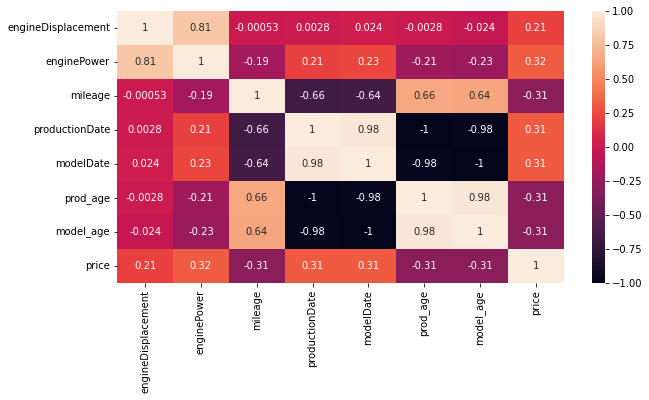

In [117]:
# построим матрицу корреляций
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['price']].corr(), annot=True)

# Cat

<AxesSubplot:>

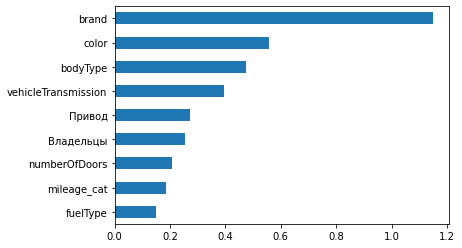

In [118]:
# проверяем значимость категориальных переменных:
temp_df = data[data['sample']==1]
imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

# Num

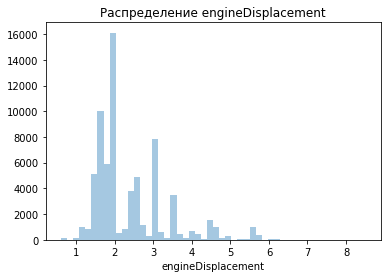

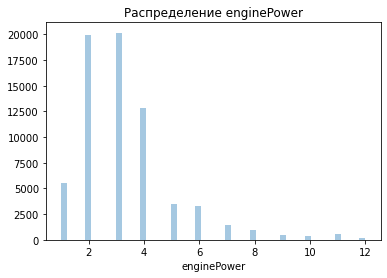

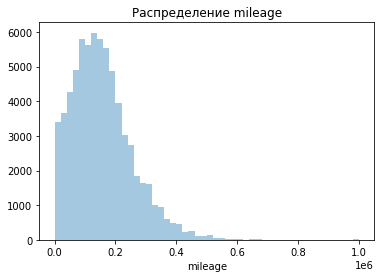

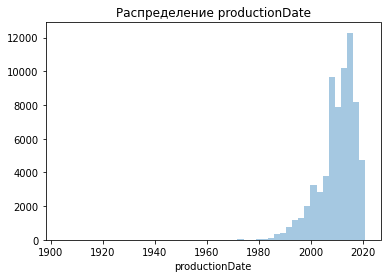

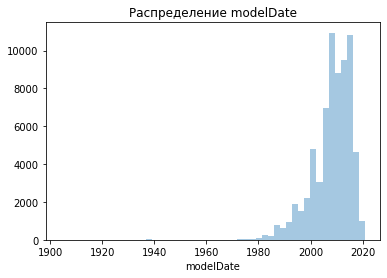

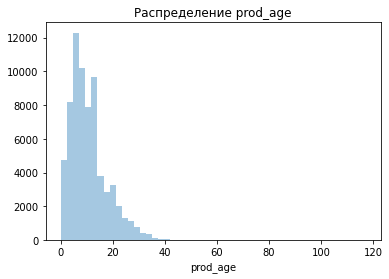

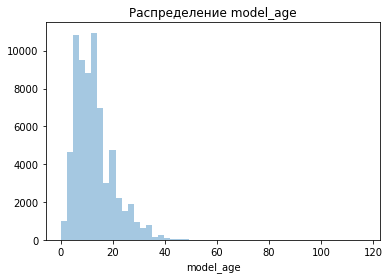

In [119]:
# смотрим распределения числовых переменных
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

<AxesSubplot:>

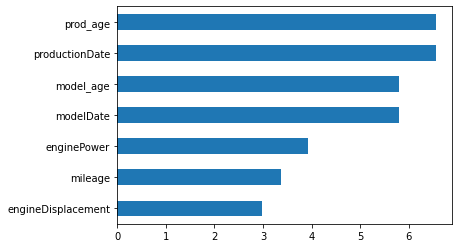

In [120]:
imp_num = Series(f_classif(data[num_cols][data['sample'] == 1], data[data['sample'] == 1]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

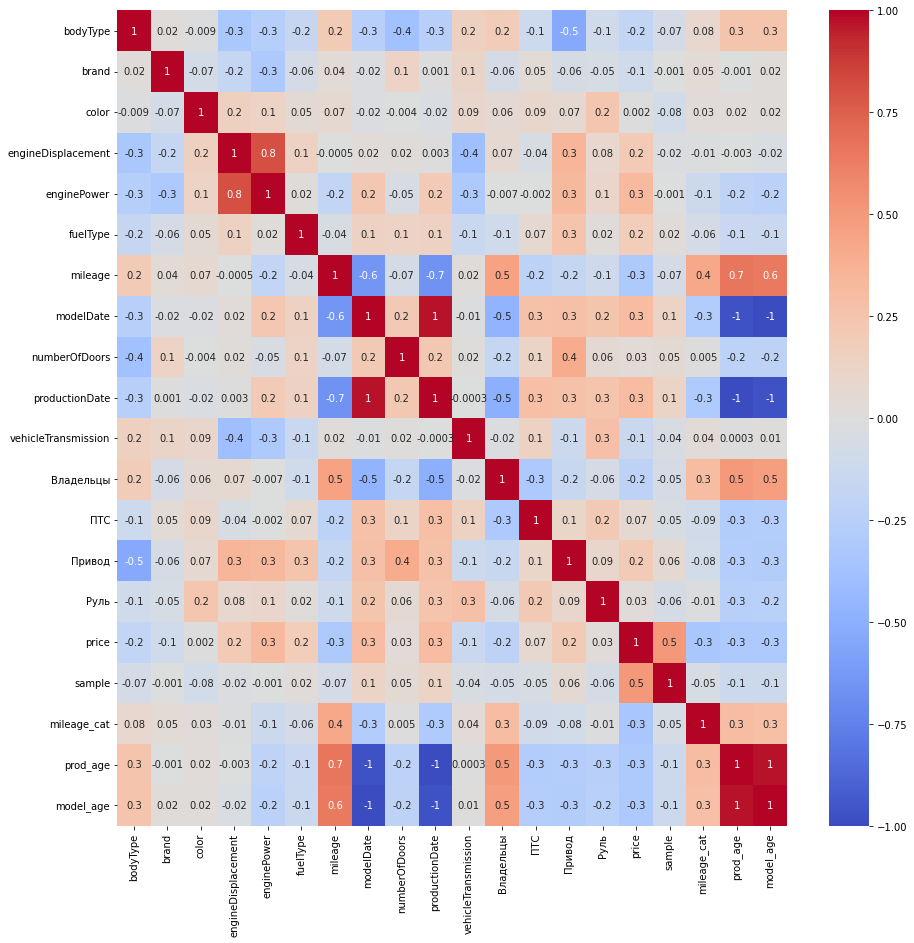

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69229 entries, 0 to 158301
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             69229 non-null  int8   
 1   brand                69229 non-null  int8   
 2   color                69229 non-null  int8   
 3   engineDisplacement   69229 non-null  float64
 4   enginePower          69229 non-null  int64  
 5   fuelType             69229 non-null  int8   
 6   mileage              69229 non-null  int64  
 7   modelDate            69229 non-null  float64
 8   numberOfDoors        69229 non-null  float64
 9   productionDate       69229 non-null  int64  
 10  vehicleTransmission  69229 non-null  int8   
 11  Владельцы            69229 non-null  float64
 12  ПТС                  69229 non-null  int8   
 13  Привод               69229 non-null  int8   
 14  Руль                 69229 non-null  int8   
 15  price                69229 non-null

## Train Split

In [123]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Linear Regression

In [124]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 29.60%


# CatBoost


In [125]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [126]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.74%


### Add Log

In [127]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")
predict_submission = np.exp(model.predict(test_data))

Точность модели по метрике MAPE: 13.85%


# xgboost

In [128]:
# xgboost
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(xb.predict(X_test))

Точность модели по метрике MAPE: 13.39%


# Gradient Boosting with best param

In [129]:
from sklearn.ensemble import GradientBoostingRegressor
def regularise(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [130]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 14.95%


# Stacking

In [131]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [132]:
regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
                            KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv)

  0%|          | 0/6 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

In [133]:
def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 15.54%


# Выводы

* CatBoost и GradientBoosting показывают хороший результат метрики, но лучший результат показал xgboost

# Submission

In [134]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.532150e+06
1,1100549428,7.357193e+06
2,1100658222,7.731002e+06
3,1100937408,5.934711e+06
4,1101037972,6.612609e+06
5,1100912634,6.315596e+06
6,1101228730,5.539667e+06
7,1100165896,3.393903e+06
8,1100768262,1.600501e+07
9,1101218501,6.989901e+06
